# Homework 2
### Surface Water Balance Model

In this exercise, we will use a simple "bucket" model of soil hydrology ([Manabe 1969](https://doi.org/10.1175/1520-0493(1969)097<0739:CATOC>2.3.CO;2)) and three formulations for evaporation to explore the surface water balance:

* [Priestley-Taylor (1972)](https://doi.org/10.1175/1520-0493(1972)100<0081:OTAOSH>2.3.CO;2) parameterization for potential evaporation.
* [Penman (1948)](https://doi.org/10.1098/rspa.1948.0037) parameterization for potential evaporation.
* [Penman-Monteith (1965)](https://repository.rothamsted.ac.uk/item/8v5v7/evaporation-and-environment) parameterization for actual evaporation.

For the first two parameterizations, we will use a "beta" formulation based on soil moisture to convert potential evaporation into actual evaporation. For Penman-Monteith, we will us a multi-stressor style approach *a la* [Jarvis (1976)](https://www.jstor.org/stable/2417554) to estimate the canopy resistance term.


In [2]:
# Import useful software packages
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd

import metpy.constants as c
import metpy.calc as calc
from metpy.units import units

### A Simple Model - in Parts

The cell below contains functions for the various parameterizations, as well as for aerodynamic resistance and the Clausius-Clapeyron relationship.

In [3]:
def bucket(timestep,soil_water,precip,evap,max_capacity=150.0*units('kg/m**2'),leaky_bucket=False):
    """
    A simple bucket hydrology model at the land surface
    
    Required inputs:
        dt                    (int) = Time step [s]
        soil_water (float or array) = Water content of the soil [kg/m^2]
        precip     (float or array) = Precipitation rate [kg/m^2/s]
        evap       (float or array) = Evaporation rate [kg/m^2/s]
        
    Optional inputs:
        max_capacity        (float) = Maximum water content of the soil [kg/m^2]
        leaky_bucket (bool) [False] = Is runoff permitted before capacity is reached? This mimics baseflow from bottom of bucket.
        
    Outputs:
        runoff     (float or array) = Runoff rate during time step [kg/m^2/s] - combines excess and any leaky bucket baseflow.
        del_water  (float or array) = Change in water content of the soil during time step [kg/m^2]
    """

    # Set some parameters
    leak_coef = 5.0e-7 / units('s')              # Rate of leaky-bucket baseflow as fraction of soil_water [s^-1]
    
    # Account for what's happening between land and atmosphere
    net_water = (precip - evap) * timestep       # Net input of water into soil from above
    soil_water_interim = soil_water + net_water  # Add net water to soil
    if soil_water_interim < 0.0:                 # Check for negative soil water
        print ("Soil water content negative: evaporation rate is unrealistically large.")
        soil_water_interim = 0.0                 # If this happens, send a message, set to zero
    
    # Calculate what's happening underground.
    if leaky_bucket:
        baseflow = leak_coef * soil_water                          # Drainage out the bottom of the soil column
    else:
        baseflow = 0.0
    surface_flow = np.maximum(0.0*units('kg/m**2'), soil_water_interim - max_capacity) / timestep  # If bucket "overflows"
    runoff = baseflow + surface_flow 
    if soil_water_interim - runoff * timestep < 0.0:               # Check for negative soil water
        print ("Soil water content negative: runoff is unrealistically large.")
        soil_water_interim = 0.0                                   # This should never happen
    
    del_water = net_water - runoff * timestep    # Remove runoff from net change in water content
    
    # Updating the soil water state is not done here - return the change in soil water along with calculated runoff
    return runoff, del_water            


def evap_beta(evap_pot,soil_water,max_capacity=150.0*units('kg/m**2')):
    """
    A beta-type evaporation model
    
    Required inputs:
        evap_pot   (float or array) = Potential evaporation rate [units to match output]
        soil_water (float or array) = Water content of the soil [kg/m^2]
        
    Optional inputs:
        max_capacity        (float) = Maximum water content of the soil [kg/m^2]
        
    Outputs:
        evap       (float or array) = Evaporation rate [units to match input]
    """

    evap = evap_pot * soil_water / max_capacity
    
    return evap
    

def clau_clap(temperature):
    """
    Returns the rate of change of saturation vapor pressure with temperature at the given 
    temperature, following the Clausius-Clapeyron relationship.
    
    Required inputs:
        temperature (float or array) = Temperature [K] at which to calculate de_s/dT
        
    Outputs:
        desdt       (float or array) = de_s/dT [Pa/K]
    """
  
    # Set some parameters
    R_v = c.water_gas_constant
    lambda_v = c.water_heat_vaporization
    triple_water = 611.2 * units('Pa')
    
    mag_t = temperature.to('celsius').m
    lambda_v = (2500.8-2.36*mag_t+0.0016*mag_t**2-0.00006*mag_t**3)*1000.0 * units('J/kg') # More accurate
    e_s = triple_water * np.exp(17.67*mag_t/(mag_t+243.5))
    
    desdt = lambda_v * e_s / (R_v * temperature.to('kelvin')**2)
    
    return desdt


def aero_res(density,exchange_coef):
    """
    Returns the aerodynamic resistance given air density and the surface exchange coefficient.
    
    Required inputs:
        density       (float or array) = air density [kg/m^3]
        exchange_coef (float or array) = surface exchange coefficient [kg/m^2/s]
        
    Outputs:
        r_a           (float or array) = aerodynamic resistance [s/m]
    """
    
    r_a = density / exchange_coef
    
    return r_a


def priestley_taylor(net_radiation,temperature):
    """
    Calculates potential evaporation based on the Priestley-Taylor equation.
    
    Required inputs:
        net_radiation (float or array) = Net radiation at the surface [W/m^2] (downward positive)
        temperature   (float or array) = Air temperature [K]
        
    Outputs:
        pot_evap      (float or array) = Potential evaporation rate [kg/m^2/s]
    """
    
    # Set some parameters
    mean_slp = 101325 * units('Pa')
    alpha = 1.26  # Priestley-Taylor coefficient [-] (accounts for entrainment of dry air into a growing boundary layer)
    lambda_v = c.water_heat_vaporization
    
    mag_t = temperature.to('celsius').m
    lambda_v = (2500.8-2.36*mag_t+0.0016*mag_t**2-0.00006*mag_t**3)*1000.0 * units('J/kg') # More accurate than the constant
    gamma = (mean_slp*c.dry_air_spec_heat_press)/(lambda_v*c.molecular_weight_ratio) # Psychrometric constant [-]

    # Energy-dependent potential evaporation
    desdt = clau_clap(temperature)
    pot_evap = alpha * desdt * net_radiation / (lambda_v * (desdt + gamma))
    
    return pot_evap


def penman(net_radiation,temperature,specific_humidity,density,
           exchange_coef,sfc_sat_spec_humid,pressure=1.0e5*units('Pa')):
    """
    Calculates potential evaporation based on the Penman equation,
        which includes both aerodynamic and energy terms.
    
    Required inputs:
        net_radiation      (float or array) = Net radiation at the surface [W/m^2] (downward positive)
        temperature        (float or array) = Surface air temperature [K]
        specific_humidity  (float or array) = Surface air specific humidity [kg/kg]
        density            (float or array) = Surface air density [kg/m^3]
        exchange_coef      (float or array) = Surface exchange coefficient for heat & moisture [kg/m^2/s]
        sfc_sat_spec_humid (float or array) = Surface saturated specific humidity [kg/kg]
        
    Optional inputs:
        pressure           (float or array) = Surface air pressure [Pa]
        
    Outputs:
        pot_evap           (float or array) = Potential evaporation rate [kg/m^2/s]
    """
    
    # Set some parameters
    mean_slp = 101325 * units('Pa')
    lambda_v = c.water_heat_vaporization
    
    mag_t = temperature.to('celsius').m
    lambda_v = (2500.8-2.36*mag_t+0.0016*mag_t**2-0.00006*mag_t**3)*1000.0 * units('J/kg') # More accurate than the constant
    gamma = (mean_slp*c.dry_air_spec_heat_press)/(lambda_v*c.molecular_weight_ratio) # Psychrometric constant [-]

    desdt = clau_clap(temperature)
    r_a = aero_res(density,exchange_coef)   # Aerodynamic resistance [s/m]
    air_vp = calc.vapor_pressure(pressure,calc.mixing_ratio_from_specific_humidity(specific_humidity))
    sfc_sat_vp = calc.vapor_pressure(pressure,calc.mixing_ratio_from_specific_humidity(sfc_sat_spec_humid))
    
    pot_evap = (desdt*net_radiation + density*c.dry_air_spec_heat_press*(sfc_sat_vp - air_vp)/r_a) / (lambda_v*(desdt + gamma))
    
    return pot_evap


def penman_monteith(net_radiation,temperature,specific_humidity,density,
                    exchange_coef,sfc_sat_spec_humid,r_surface,pressure=1.0e5*units('Pa')):
    """
    Calculates evaporation based on the Penman-Monteith equation,
        which includes a surface resistance term to reduce evaporation below the potential rate.
    
    Required inputs:
        net_radiation      (float or array) = Net radiation at the surface [W/m^2] (downward positive)
        temperature        (float or array) = Surface air temperature [K]
        specific_humidity  (float or array) = Surface air specific humidity [kg/kg]
        density            (float or array) = Surface air density [kg/m^3]
        exchange_coef      (float or array) = Surface exchange coefficient for heat & moisture [kg/m^2/s]
        sfc_sat_spec_humid (float or array) = Surface saturated specific humidity [kg/kg]
        r_surface          (float or array) = Surface resistance [s/m]
        
    Optional inputs:
        pressure           (float or array) = Surface air pressure [Pa]
        
    Outputs:
        pot_evap           (float or array) = Potential evaporation rate [kg/m^2/s]
    """
    
    # Set some parameters
    mean_slp = 101325 * units('Pa')
    lambda_v = c.water_heat_vaporization
    
    mag_t = temperature.to('celsius').m
    lambda_v = (2500.8-2.36*mag_t+0.0016*mag_t**2-0.00006*mag_t**3)*1000.0 * units('J/kg') # More accurate than the constant
    gamma = (mean_slp*c.dry_air_spec_heat_press)/(lambda_v*c.molecular_weight_ratio) # Psychrometric constant [-]

    desdt = clau_clap(temperature)
    r_a = aero_res(density,exchange_coef)   # Aerodynamic resistance [s/m]
    air_vp = calc.vapor_pressure(pressure,calc.mixing_ratio_from_specific_humidity(specific_humidity))
    sfc_sat_vp = calc.vapor_pressure(pressure,calc.mixing_ratio_from_specific_humidity(sfc_sat_spec_humid))
    
    evap = (desdt*net_radiation + density*c.dry_air_spec_heat_press*(sfc_sat_vp - air_vp)/r_a) \
               / (lambda_v*(desdt + (1 + r_surface/r_a)*gamma))
    
    return evap


def canopy_resistance(iswc,net_shortwave,temperature,specific_humidity,sfc_temperature,
                      pressure=1.0e5*units('Pa'),min_canopy_res=60*units('s/m')):
    """
    Parameterization of canopy resistance based on four plant stresses:
        • soil water availability
        • light availability
        • vapor pressure deficit (air dryness)
        • temperature 
        Following Sellers and Dorman (1987)
    
    Required inputs:
        soil_water         (float or array) = Water content of the soil [kg/m^2]
        net_shortwave      (float or array) = Net shortwave radiation at the surface [W/m^2] (downward positive)
        temperature        (float or array) = Surface air temperature [K]
        specific_humidity  (float or array) = Surface air specific humidity [kg/kg]
        sfc_temperature    (float or array) = Surface skin temperature [K]

    Optional inputs:
        pressure           (float or array) = Surface air pressure [Pa]
        min_canopy_res     (float or array) = Minimum (optimum unstressed) canopy resistance [s/m]

    Outputs:
        canopy_res         (float or array) = Canopy resistance [s/m]
        
    Notes: 
        Instead of net shortwave radiation, downward shortwave radiation should be used, or more precisely 
        downward PAR (photosynthetically-active radiation), which closely corresponds to visible light.
    """
    # Set some parameters
    min_t = 0 * units('celsius')
    max_t = 45 * units('celsius') # A parabola will be fitted to 0 at these temperatures, and 1 at the midpoint 
    max_vpd = 4000 * units('Pa')
    lambda_v = c.water_heat_vaporization
    
    # Soil water stress factor
    f0 = np.maximum(evap_beta(1,iswc), 1.0e-6)

    # Tempeature stress factor
    h1 = 1/((max_t - min_t)/2)**2
    f1 = np.maximum((h1*(sfc_temperature-min_t)*(max_t-sfc_temperature)).m, 0.01)

    # Vapor pressure stress factor
    air_vp = calc.vapor_pressure(pressure,calc.mixing_ratio_from_specific_humidity(specific_humidity))
    sat_vp = calc.saturation_vapor_pressure(temperature)
    vpd = sat_vp - air_vp
    f2 = np.minimum(np.maximum(1 - (vpd/max_vpd).m, 0.05) ,1.0)

    # Light stress factor
    par = 0.5 * net_shortwave  # Approximate PAR
    a3, b3 = -25, 25
    f3 = np.maximum(1 + a3/(b3 + par.m), 0.15) 
    
    canopy_res = min_canopy_res / (f0*f1*f2*f3)
    
    # print(canopy_res,f1,f2,f3)
    
    return canopy_res


## A. Run the bucket model with no baseflow

To drive our simple bucket model, we will use hourly meteorological data spanning one year from the MERRA-2 reanalysis (full name: the Modern-Era Retrospective Analysis for Research and Applications, Version 2; [Gelaro et al. 2017](https://doi.org/10.1175/JCLI-D-16-0758.1)) at a single grid cell over Hubei Province, China. Time-varying data used as boundary conditions to drive a model are often called **forcing data**.

The data span 1 January - 31 December 2020. We will initialize the model soil water content (our only state variable) and run it for the full year.

In [4]:
# The data from MERRA-2 - with proper units assigned.
merra2 = xr.open_dataset("Hubei_2020_MERRA-2_hourly.nc")     #### Using xarray to read a NetCDF file
p_merra2 = merra2['PRECTOTCORR'].values * units('kg/m**2/s') # Precipitation rate
ta_merra2 = merra2['TLML'].values * units('kelvin')          # Surface air temperature
qa_merra2 = merra2['QLML'].values * units('kg/kg')           # Surface air specific humidity
ts_merra2 = merra2['TSH'].values * units('kelvin')           # Effective surface skin temperature
qs_merra2 = merra2['QSH'].values * units('kg/kg')            # Effective surface specific humidity (saturated value at skin temperature)
rho_merra2 = merra2['RHOA'].values * units('kg/m**3')        # Surface air density
ch_merra2 = merra2['CDH'].values * units('kg/m**2/s')        # Surface exchange coefficient for heat & moisture
swn_merra2 = merra2['SWLAND'].values * units('W/m**2')       # Surface net shortwave radiation (positive downward)
lwn_merra2 = merra2['LWLAND'].values * units('W/m**2')       # Surface net longwave radiation (positive downward)
e_merra2 = merra2['EVLAND'].values * units('kg/m**2/s')      # Surface evaporation (positive upward)
time_merra2 = merra2['time']

### Case 1
* A bucket model without baseflow (i.e., our bucket *does not leak* - water can only leave by evaporation or by spilling over the top)
* Potential evaporation from the Priestley-Taylor formulation (requires the least amount of input data)
* Beta-parameterization to estimate actual evaporation from potential evaporation

In [5]:
##############################################################
##############################################################
### Parameters for this exercise:
timestep = 3600 * units('sec')    # 3600 seconds = one hour
init_swc = 75 * units('kg/m**2')  # initial soil water content
##############################################################
##############################################################

# Set up empty arrays to hold the output for later display and comparison
swc_1   = np.zeros(shape=(len(p_merra2))) * units('kg/m**2')   # Soil water content 
p_in_1  = np.zeros_like(swc_1) * units('kg/m**2')              # Precipitation in each timestep
e_out_1 = np.zeros_like(swc_1) * units('kg/m**2')              # Evaporation in each timestep
r_out_1 = np.zeros_like(swc_1) * units('kg/m**2')              # Runoff in each timestep

# Modeling block #########
iswc = init_swc                    # Initialize the soil water state
for i in range(len(time_merra2)):  # Run through length of forcing data set
    if i % 120 == 0:               # This if-block prints symbols every 1 & 5 days so you can see the progress.
        print("|",end="")
    elif (i % 24 == 0) and (i % 120 != 0):
        print(".",end="")
        
    # Calculate evaporation for the time step
    pe_rate = priestley_taylor(swn_merra2[i]+lwn_merra2[i],ta_merra2[i])
    e_rate = evap_beta(pe_rate,iswc)
    # Precipitation is part of the forcing data
    p_rate = p_merra2[i]
    # P and E are inputs to our bucket model, runoff and change in water storage are outputs
    roff,del_swc = bucket(timestep,iswc,p_rate,e_rate)
    iswc += del_swc                 # Update our state variable 
    # Save the values of state and fluxes in time series for later plotting
    swc_1[i] = iswc                 
    p_in_1[i] = p_rate * timestep
    e_out_1[i] = e_rate * timestep
    r_out_1[i] = roff * timestep

print("\n*** DONE ***")

|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|
*** DONE ***


Text(0.5, 0.98, 'Case 1: Bucket Hydrology, Priestley-Taylor & Beta Evaporation')

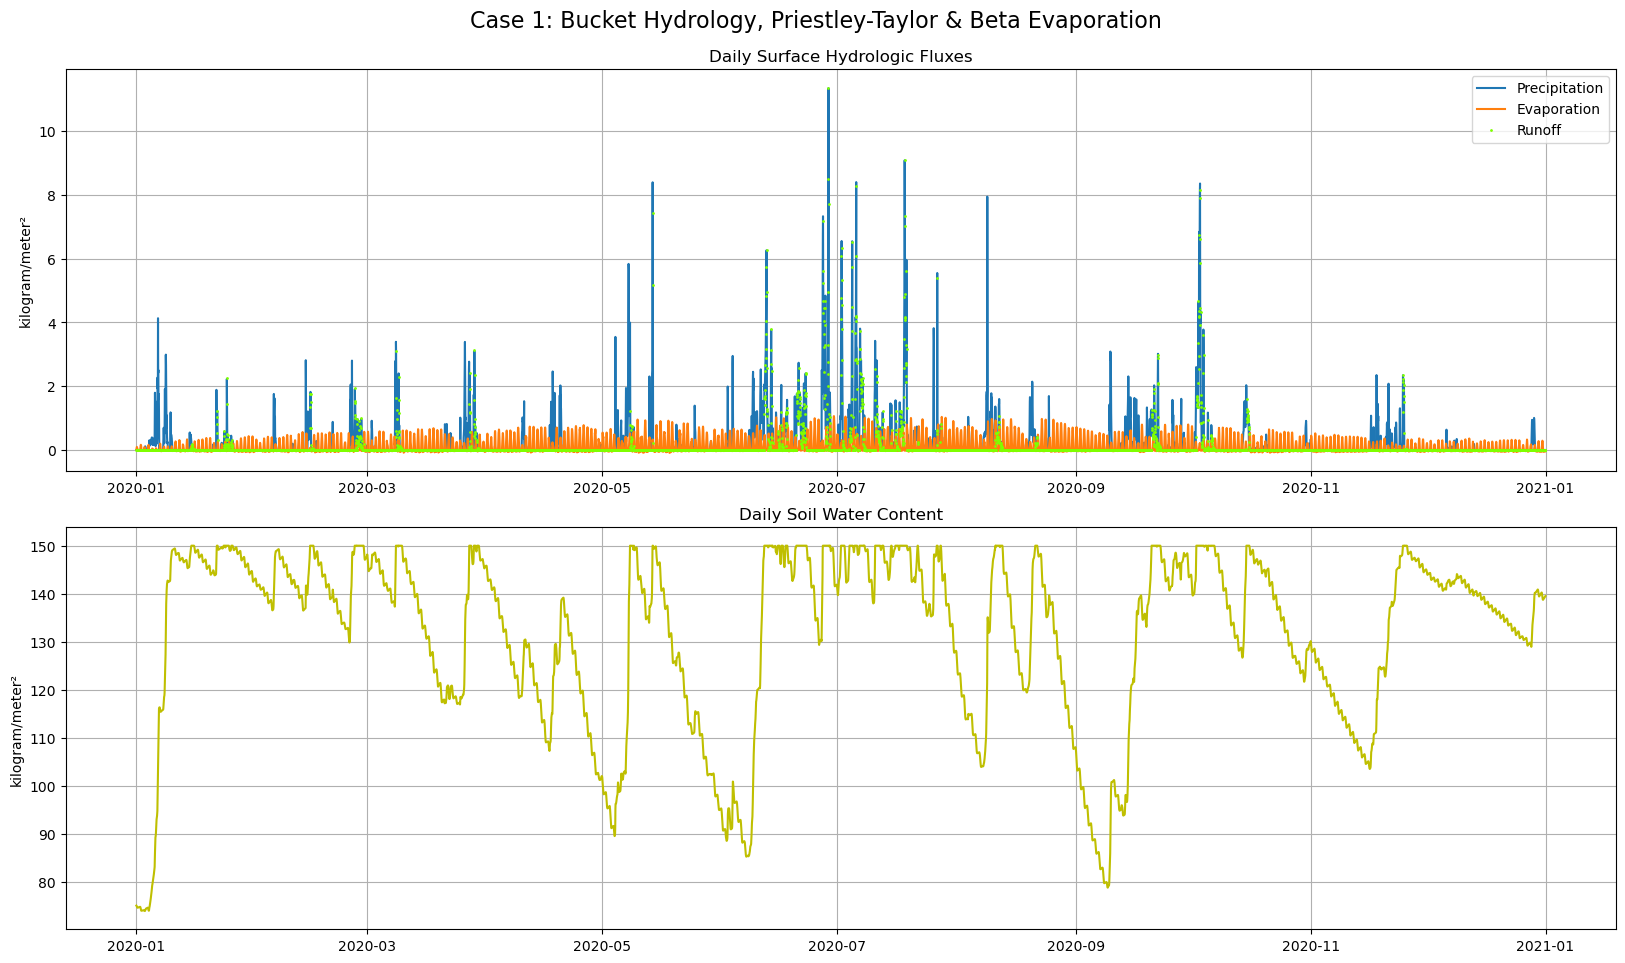

In [6]:
# Plotting block #########
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1*plot_scale))
plt.subplots_adjust(top=0.92,bottom=0.06,hspace=0.14)
# Subplots without axes - not very pythonic, but OK for simple plots
plt.subplot(2,1,1)  # The first of two panels
plt.plot(time_merra2,p_in_1)
plt.plot(time_merra2,e_out_1)
plt.plot(time_merra2,r_out_1,color='chartreuse',lw=0,marker='o',ms=1)
plt.grid()
plt.legend(["Precipitation","Evaporation","Runoff"])
plt.title("Daily Surface Hydrologic Fluxes")

plt.subplot(2,1,2)  # The second of two panels
plt.plot(time_merra2,swc_1,c='y')
plt.grid()
plt.title("Daily Soil Water Content")
plt.suptitle("Case 1: Bucket Hydrology, Priestley-Taylor & Beta Evaporation",fontsize=16)

### Answer some questions
In the cell below, write your answers to these questions:
1. In the periods between rain events, the soil water content goes down in stairsteps. Look closely and you will see the stairs are steepest during late summer and least steep at the start and end of the year. Why do you think this is so (consider the location of this simulation, the variables that are in the Priestley-Taylor formulation and how they vary throughout the year)?
2. Because our bucket model is not leaky, runoff only occurs when the bucket is full. If the world looked like this model, how would the streams and rivers behave? Does this seem realistic or not? Why? 

### Answers

1. During the summer months, there is more sunlight (and higher temperatures) and thus more energy to cause the evaporation rate to increase and lead to soil moisture decreasing more quickly, as opposed to the winter months when there is less energy (and lower temperatures) and thus the evaporation rate is lower, leading to soil moisture decreasing more slowly. 

- Steeper = soil is getting drier more quickly, less steep = soil is drying out more slowly (retaining moisture longer).
- Priestly-Taylor forumla takes in net radiation and temperature as function parameters to estimate potential evaporation. 
- Beta-parameterization uses p_e rate from p_t formula and soil water amount as inputs to estimate evaporation rates.

2. This isn't realistic, since streams and rivers would flood every time the soil water content met a certain threshold, which would be met quickly during periods of high precipitation (as seen in the plot above). 


### Case 2
* As in Case 1, but the potential evaporation is from the Penman formulation

In [7]:
# Set up empty arrays to hold the output for later display and comparison
swc_2   = np.zeros(shape=(len(p_merra2))) * units('kg/m**2')  # Soil water content 
p_in_2  = np.zeros_like(swc_2) * units('kg/m**2')             # Precipitation in each timestep
e_out_2 = np.zeros_like(swc_2) * units('kg/m**2')             # Evaporation in each timestep
r_out_2 = np.zeros_like(swc_2) * units('kg/m**2')             # Runoff in each timestep

# Modeling block #########
iswc = init_swc                    # Initialize the soil water state
for i in range(len(time_merra2)):  # Run through length of forcing data set
    if i % 120 == 0:               # This if-block prints symbols every 1 & 5 days so you can see the progress.
        print("|",end="")
    elif (i % 24 == 0) and (i % 120 != 0):
        print(".",end="")
        
    # Calculate evaporation for the time step
    pe_rate = penman(swn_merra2[i]+lwn_merra2[i],ta_merra2[i],qa_merra2[i],
                     rho_merra2[i],ch_merra2[i],qs_merra2[i])
    e_rate = evap_beta(pe_rate,iswc)
    # Precipitation is part of the forcing data
    p_rate = p_merra2[i]
    # P and E are inputs to our bucket model, runoff and change in water storage are outputs
    roff,del_swc = bucket(timestep,iswc,p_rate,e_rate)
    iswc += del_swc                 # Update our state variable 
    # Save the values of state and fluxes in time series for later plotting
    swc_2[i] = iswc
    p_in_2[i] = p_rate * timestep
    e_out_2[i] = e_rate * timestep
    r_out_2[i] = roff * timestep

print("\n*** DONE ***")

|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|
*** DONE ***


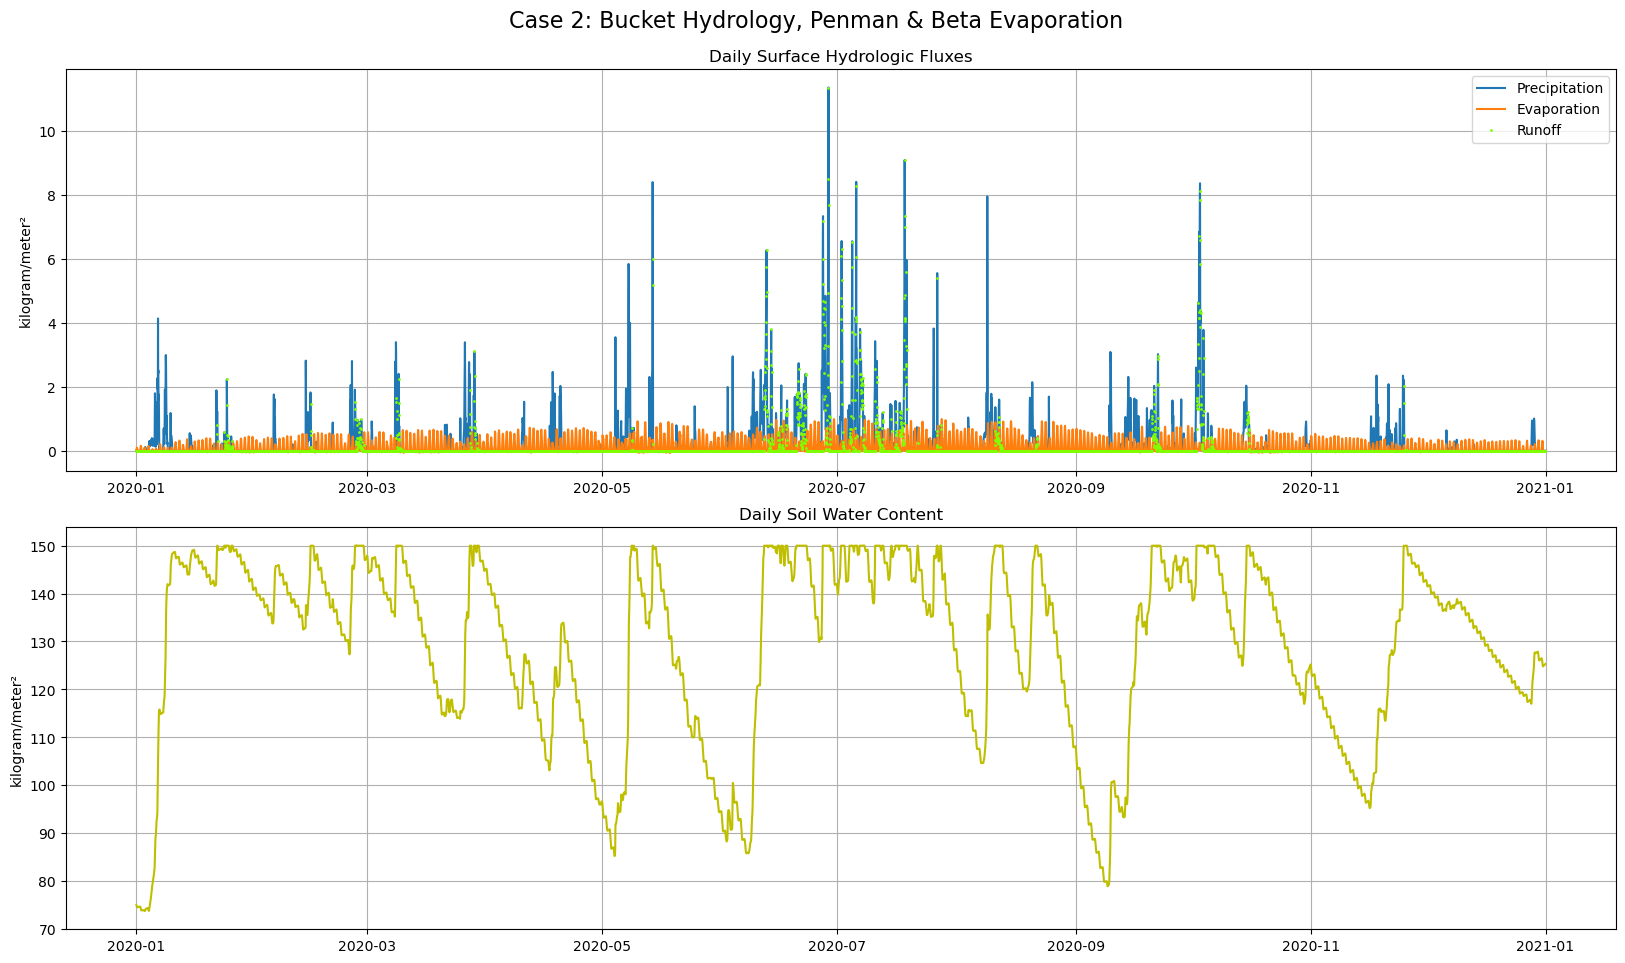

In [8]:
# Plotting block
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1*plot_scale))
plt.subplots_adjust(top=0.92,bottom=0.06,hspace=0.14)
plt.subplot(2,1,1)  # The first of two panels
plt.plot(time_merra2,p_in_2)
plt.plot(time_merra2,e_out_2)
plt.plot(time_merra2,r_out_2,color='chartreuse',lw=0,marker='o',ms=1)
plt.grid()
plt.legend(["Precipitation","Evaporation","Runoff"])
plt.title("Daily Surface Hydrologic Fluxes")
plt.subplot(2,1,2)  # The second of two panels
plt.plot(time_merra2,swc_2,c='y')
plt.grid()
plt.title("Daily Soil Water Content")
plt.suptitle("Case 2: Bucket Hydrology, Penman & Beta Evaporation",fontsize=16) ;

### Answer some questions
1. At first glance, it is hard to see much difference from Case 1. Copy the plotting block cell below and modify it to plot 3 panels: one of the soil water content from both cases (`swc_1` and `swc_2`), one comparing the evaporations (just plot the difference: `e_out_2-e_out_1`) and one comparing the runoffs (`r_out_2-r_out_1`). Precipitation is the same - that was specified as a boundary condition.
2. Describe any significant differences you see in the raw text cell below, particularly any patterns you notice.

Text(0.5, 0.98, 'Bucket Hydrology, Case 1 and 2 Comparison')

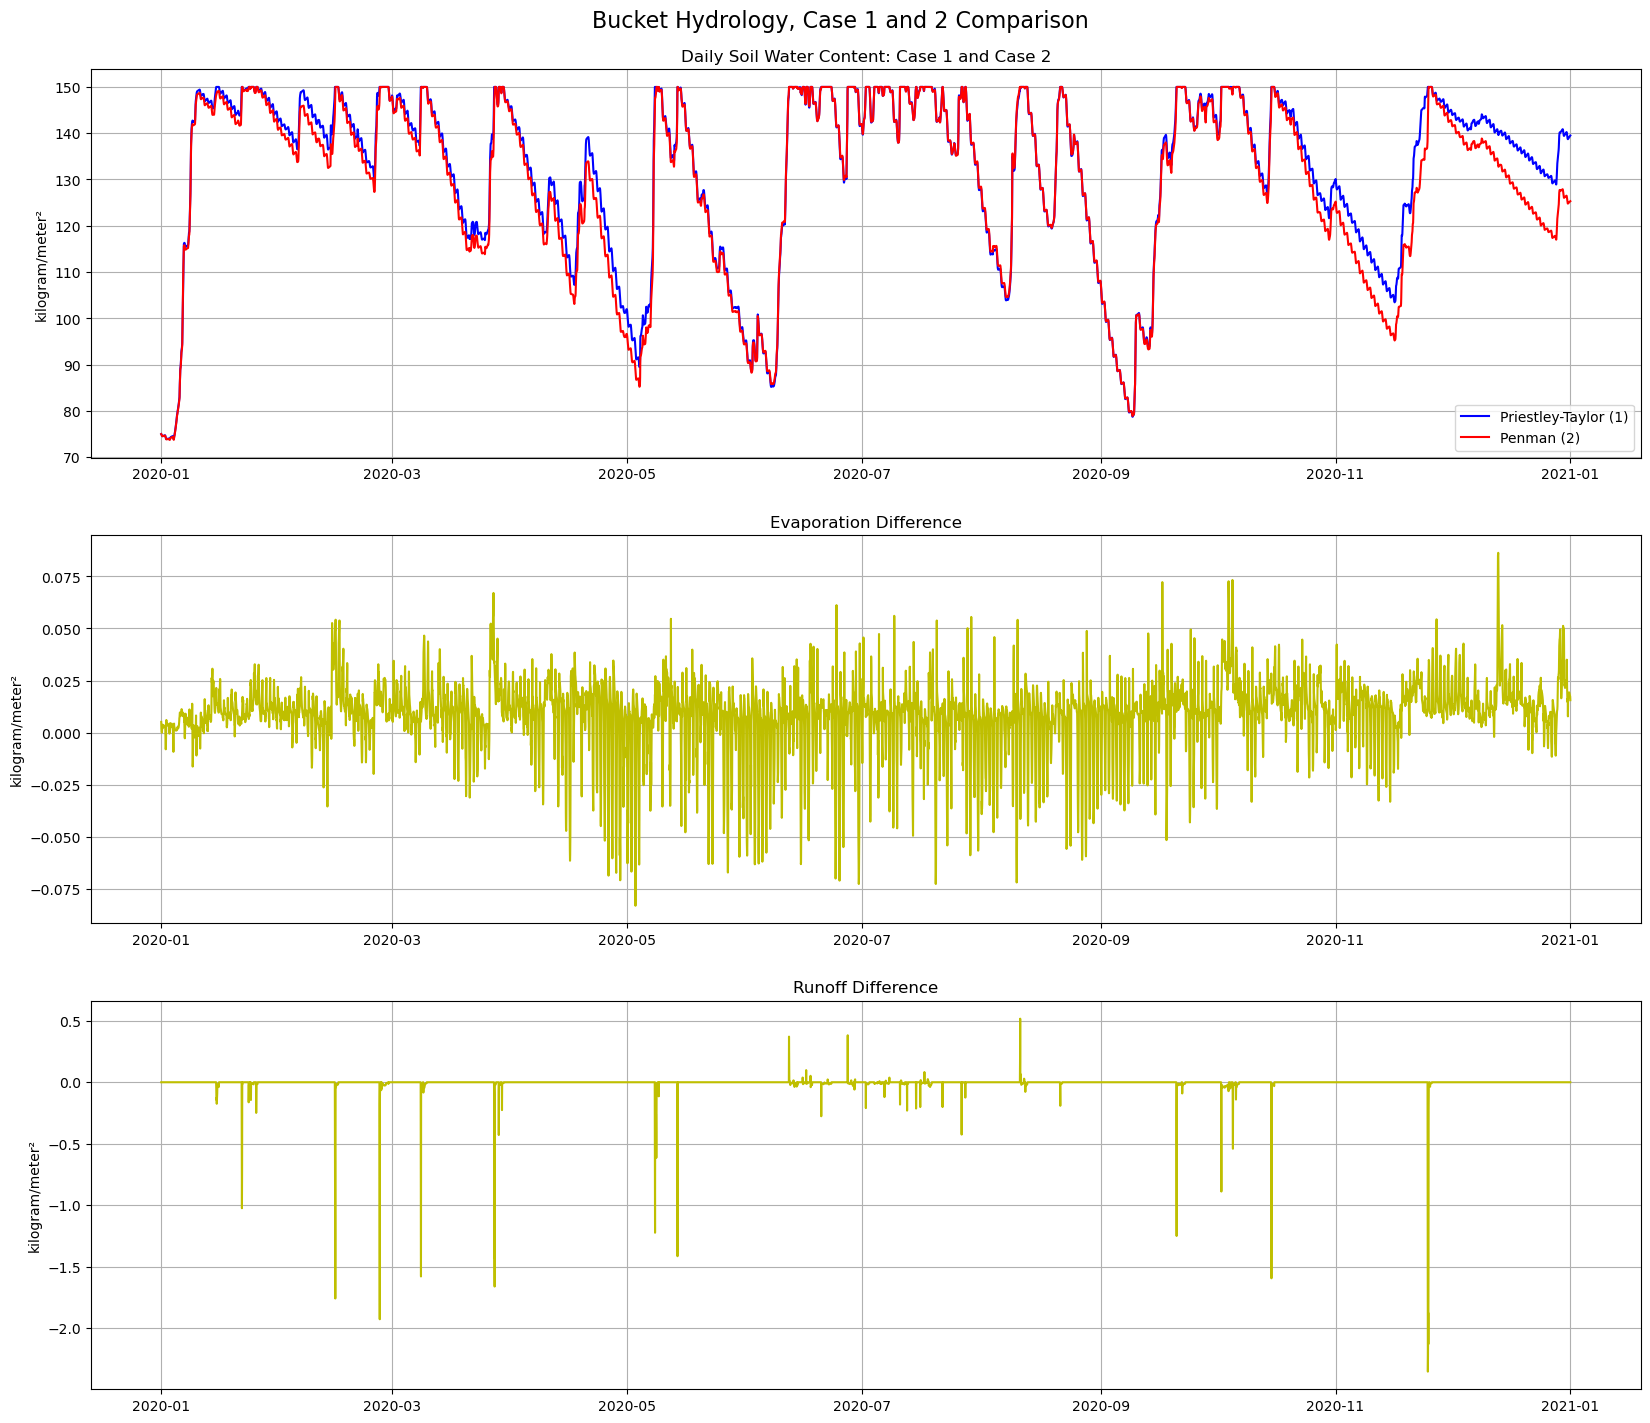

In [21]:
# 1. 
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1.5*plot_scale))
plt.subplots_adjust(top=0.94, bottom=0.06)

plt.subplot(3,1,1)  # The first of three panels
plt.plot(time_merra2, swc_1, c='b')
plt.plot(time_merra2, swc_2, c='r')
plt.grid()
plt.title("Daily Soil Water Content: Case 1 and Case 2")
plt.legend(["Priestley-Taylor (1)", "Penman (2)"])

plt.subplot(3,1,2)  # The second of three panels
plt.plot(time_merra2, e_out_2-e_out_1, c='y')
plt.grid()
plt.title("Evaporation Difference")

plt.subplot(3,1,3)  # The third of three panels
plt.plot(time_merra2, r_out_2-r_out_1, c='y')
plt.grid()
plt.title("Runoff Difference")

plt.suptitle("Bucket Hydrology, Case 1 and 2 Comparison", fontsize=16)

### Answers

2. The first plot shows that the two formulas estimate the soil water content to be very similar from the beginning of May to about mid-October, while the Priestley-Taylor formula seems to estimate higher soil water content during the other months (especially towards the end of the year). Interestingly, it looks like evaporation differences are slightly larger during a similar range of May to October and slightly smaller for the other months. The runoff differences are also smaller during the middle of the year and larger during the beginning and end of the year. Both difference plots tend to have more negative values, suggesting that the Priestley-Taylor values are larger than the Penman values more of the time.

- Case 1 = Priestley-Taylor data, Case 2 = Penman data, difference plots = 2-1

### Case 3
* A bucket model without baseflow, like before
* Evaporation from the Penman-Monteith formulation
* Surface resistance calculated based on estimated plant stresses

In [17]:
# Set up empty arrays to hold the output for later display and comparison
swc_3   = np.zeros(shape=(len(p_merra2))) * units('kg/m**2')  # Soil water content 
p_in_3  = np.zeros_like(swc_3) * units('kg/m**2')             # Precipitation in each timestep
e_out_3 = np.zeros_like(swc_3) * units('kg/m**2')             # Evaporation in each timestep
r_out_3 = np.zeros_like(swc_3) * units('kg/m**2')             # Runoff in each timestep

# Modeling block #########
iswc = init_swc                    # Initialize the soil water state
for i in range(len(time_merra2)):  # Run through length of forcing data set
    if i % 120 == 0:               # This if-block prints symbols every 1 & 5 days so you can see the progress.
        print("|",end="")
    elif (i % 24 == 0) and (i % 120 != 0):
        print(".",end="")
        
    # Calculate evaporation for the time step
    r_s = canopy_resistance(iswc,swn_merra2[i],ta_merra2[i],qa_merra2[i],ts_merra2[i])    
    e_rate = penman_monteith(swn_merra2[i]+lwn_merra2[i],ta_merra2[i],qa_merra2[i],
                             rho_merra2[i],ch_merra2[i],qs_merra2[i],r_s)

    # Precipitation is part of the forcing data
    p_rate = p_merra2[i]
    # P and E are inputs to our bucket model, runoff and change in water storage are outputs
    roff,del_swc = bucket(timestep,iswc,p_rate,e_rate)
    iswc += del_swc                 # Update our state variable 
    # Save the values of state and fluxes in time series for later plotting
    swc_3[i] = iswc
    p_in_3[i] = p_rate * timestep
    e_out_3[i] = e_rate * timestep
    r_out_3[i] = roff * timestep

print("\n*** DONE ***")

|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|
*** DONE ***


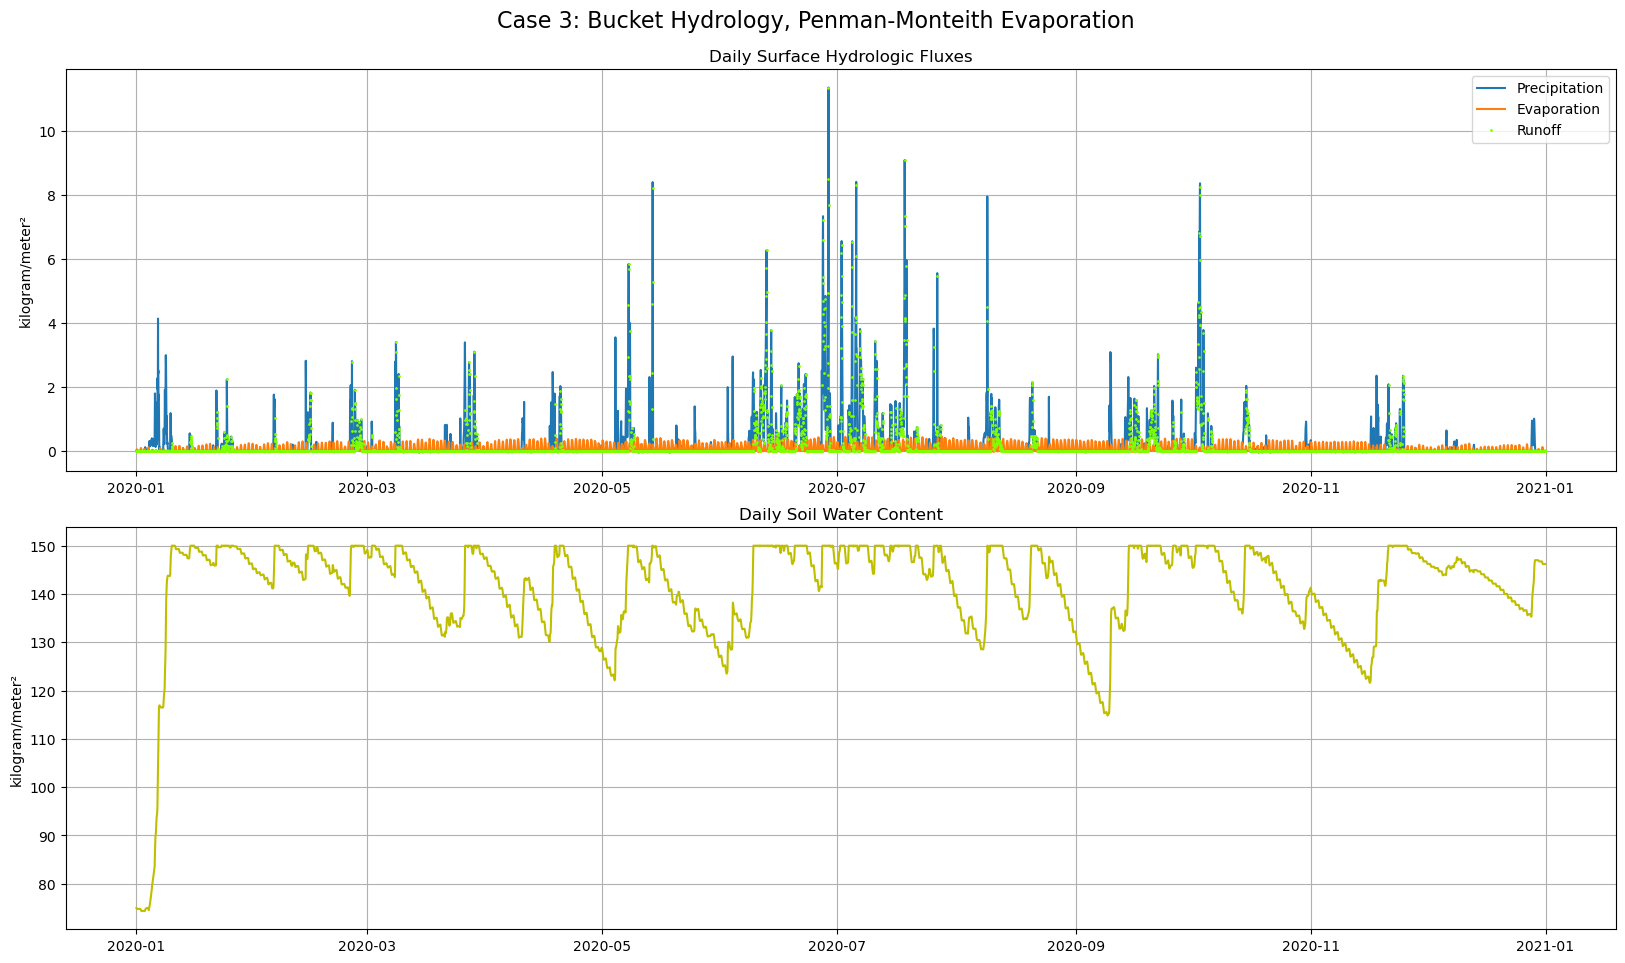

In [ ]:
# Plotting block #########
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1*plot_scale))
plt.subplots_adjust(top=0.92,bottom=0.06,hspace=0.14)
# Subplots without axes - not very pythonic, but OK for simple plots
plt.subplot(2,1,1) 
plt.plot(time_merra2,p_in_3)
plt.plot(time_merra2,e_out_3)
plt.plot(time_merra2,r_out_3,color='chartreuse',lw=0,marker='o',ms=1)
plt.grid()
plt.legend(["Precipitation","Evaporation","Runoff"])
plt.title("Daily Surface Hydrologic Fluxes")
plt.subplot(2,1,2)
plt.plot(time_merra2,swc_3,c='y') ## NOTE: code originally had swc_1, so I changed it to swc_3
plt.grid()
plt.title("Daily Soil Water Content")
plt.suptitle("Case 3: Bucket Hydrology, Penman-Monteith Evaporation",fontsize=16) ;

### Answer some questions
1. As you did above, copy a plotting block cell below and modify it to plot the differences between Penman and Penman-Monteith (Cases 3 vs Case 2).
2. What was the impact Monteith's modification? The evaporation in Penman-Monteith is almost always less, yet not *always* - how can this be?

Text(0.5, 0.98, 'Bucket Hydrology, Case 2 and 3 Comparison')

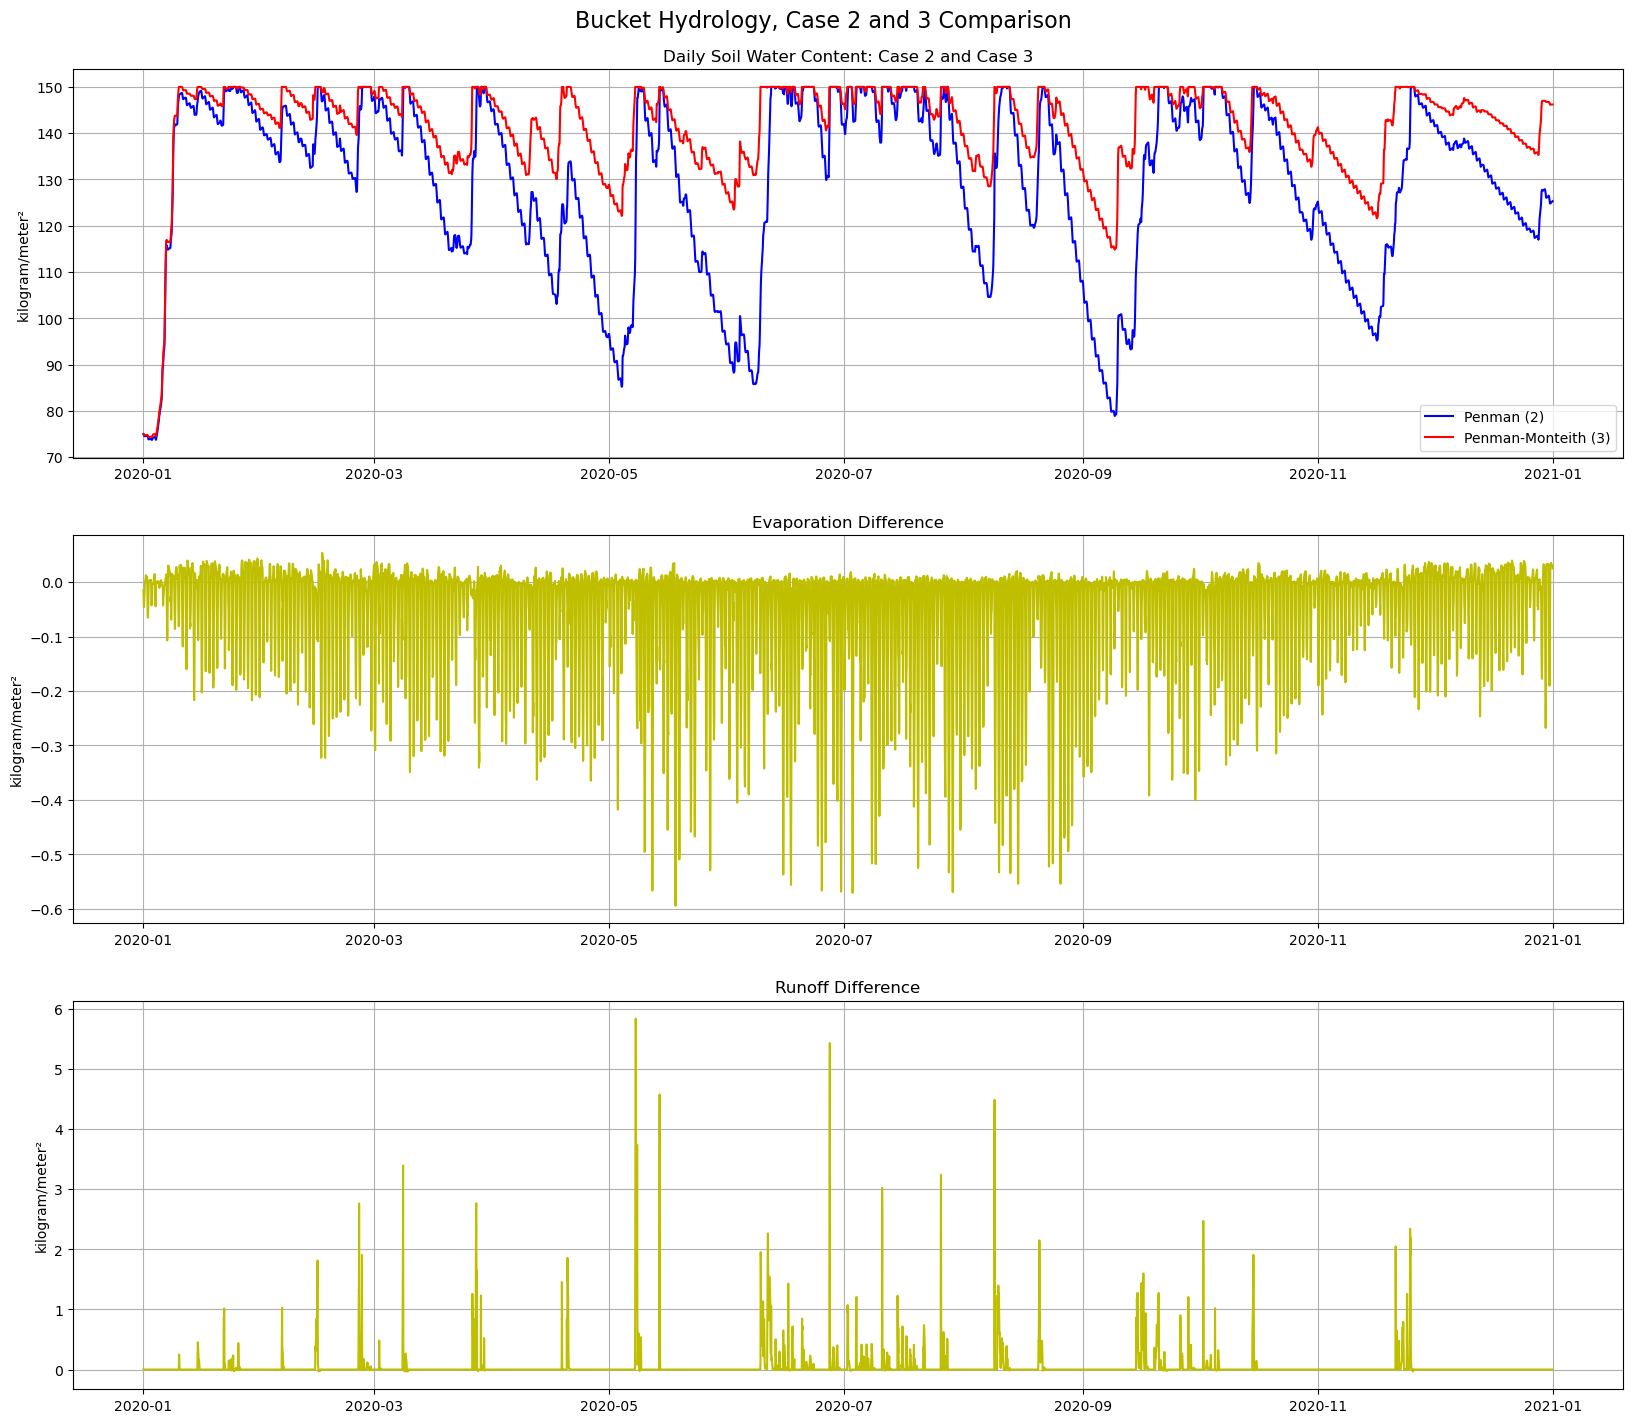

In [22]:
# 1. 
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1.5*plot_scale))
plt.subplots_adjust(top=0.94, bottom=0.06)

plt.subplot(3,1,1)  # The first of three panels
plt.plot(time_merra2, swc_2, c='b')
plt.plot(time_merra2, swc_3, c='r')
plt.grid()
plt.title("Daily Soil Water Content: Case 2 and Case 3")
plt.legend(["Penman (2)", "Penman-Monteith (3)"])

plt.subplot(3,1,2)  # The second of three panels
plt.plot(time_merra2, e_out_3-e_out_2, c='y')
plt.grid()
plt.title("Evaporation Difference")

plt.subplot(3,1,3)  # The third of three panels
plt.plot(time_merra2, r_out_3-r_out_2, c='y')
plt.grid()
plt.title("Runoff Difference")

plt.suptitle("Bucket Hydrology, Case 2 and 3 Comparison", fontsize=16)

### Answers

2. Monteith's contribution (including the canopy/surface resistance) appears to reduce the overall soil water content over the year. The evaporation difference plot shows that the Penman data vaules are almost always larger than the Penman-Monteith values (by a considerable amount, up to -0.6 $kg/m^2$, as compared to the plot comparing the Priestley-Taylor data with Penman data, where differences were always less than +/-0.1 $kg/m^2$). Similarly (but in the oppotsite direction), in the runoff difference plot, the Penman-Monteith vaules are always larger than the Penman values, and by a larger amount than the previous case comparison. The Penman-Monteith formula calculates the evaporation rate directly and includes a surface resistance parameter, while the Penman formula estimates potential evaporation and then uses the beta formulation to estimate actual evaporation rates, which leads to the evaporation rate calculated by the Penman-Monteith being slightly higher than the Penman estimate on occasion. 

- Case 2 = Penman data, Case 3 = Penman-Monteith data, difference plots = 3-2

---------------
## B. Compare the cases further

Let's filter out the diurnal cycle and examine the day-to-day variations. The cell below will apply a 24-hour running mean to the data to filter out the diurnal cycle, and plot our variables.  For evaporation, we will also include the MERRA-2 data, which is calculated by the LSM in the NASA/GSFC/GMAO global Earth system model, called the Catchment model ([Koster et al. 2000](https://doi.org/10.1029/2000JD900327); [Ducharne et al. 2000](https://doi.org/10.1029/2000JD900328)).

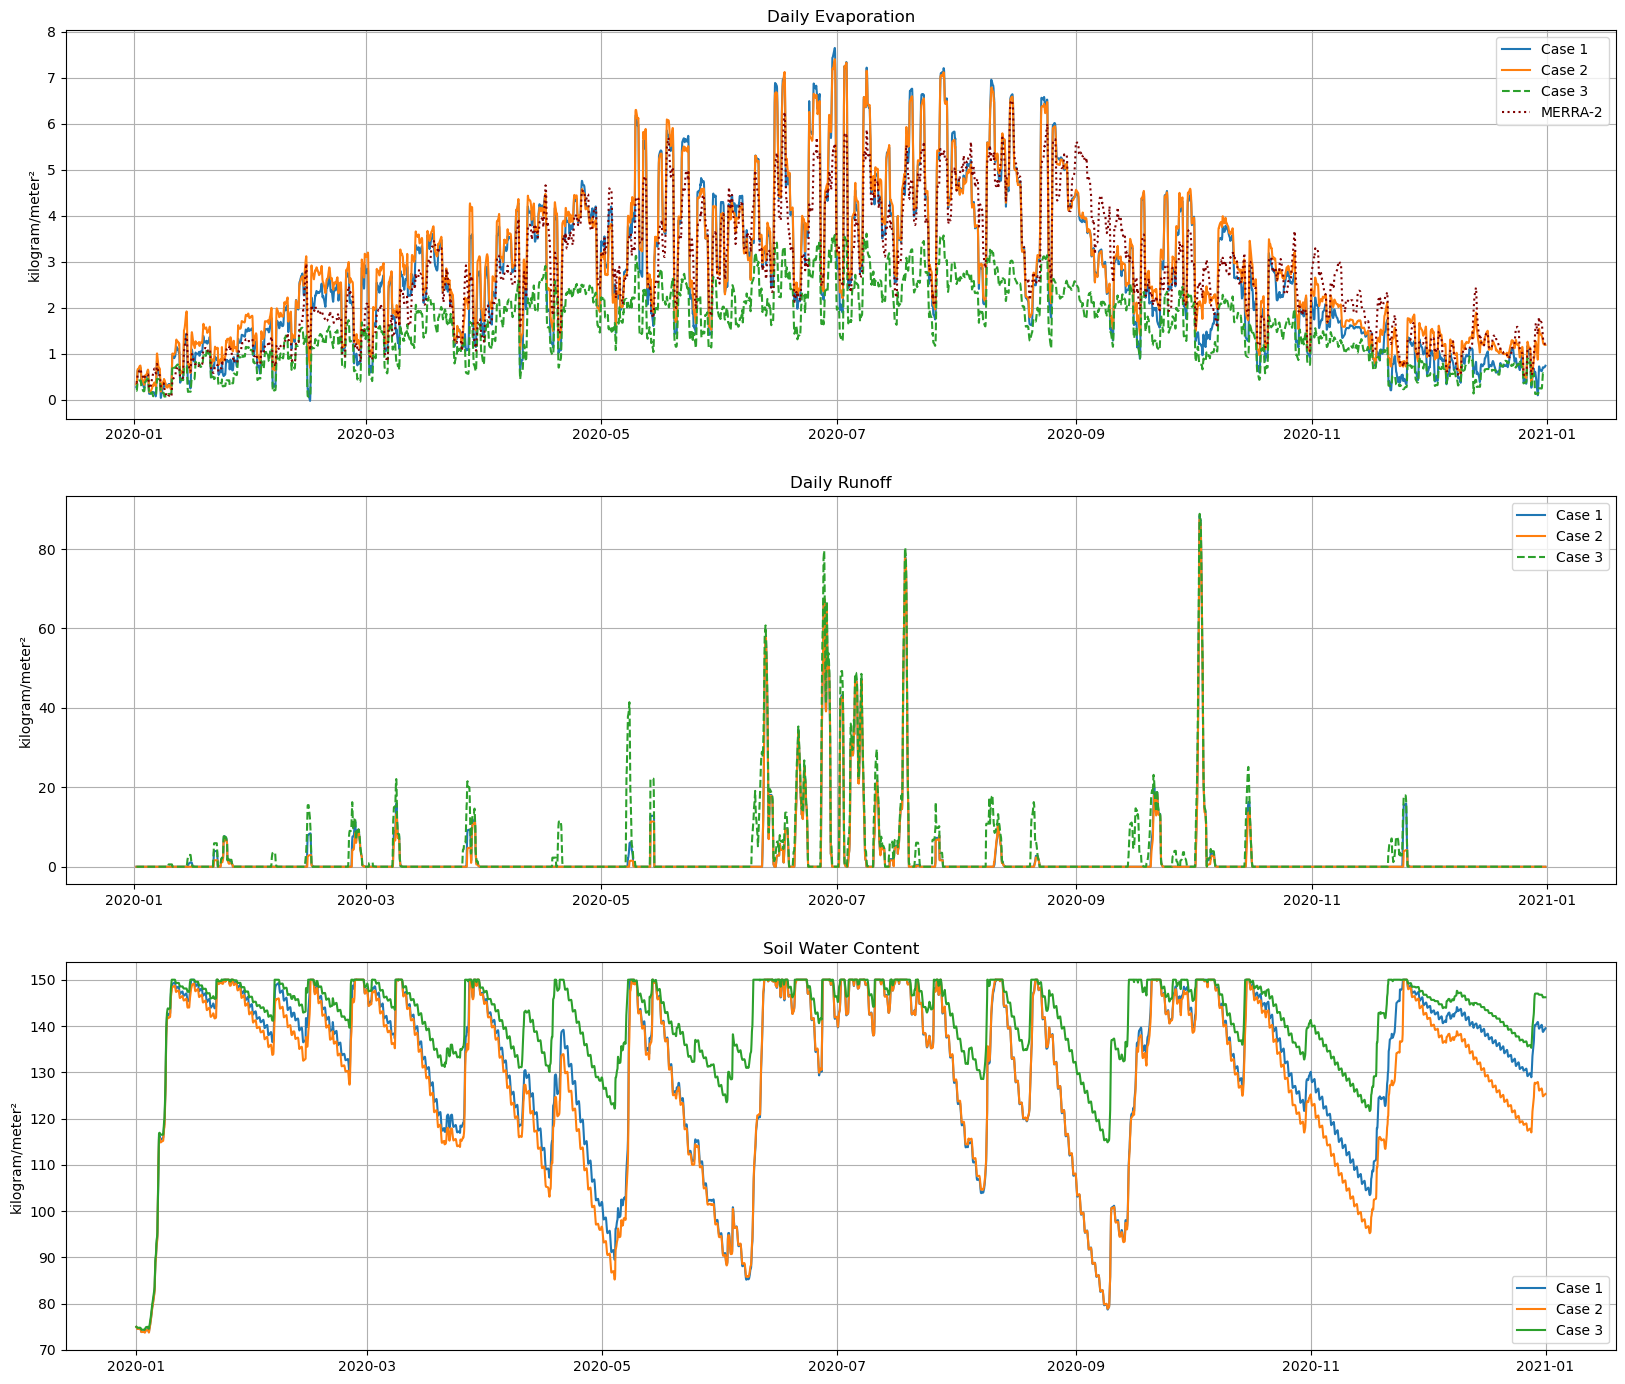

In [23]:
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1.5*plot_scale))
plt.subplots_adjust(top=0.94,bottom=0.06)

plt.subplot(3,1,1)
# Note: The Pandas rolling mean function is super useful, but it doesn't handle Pint units, 
#       so we have to convert back to NumPy arrays and put units back in (*.u) after we are done 
plt.plot(time_merra2,np.array(pd.Series(e_out_1).rolling(24,center=True).sum()) * e_out_1.u)
plt.plot(time_merra2,np.array(pd.Series(e_out_2).rolling(24,center=True).sum()) * e_out_2.u)
plt.plot(time_merra2,np.array(pd.Series(e_out_3).rolling(24,center=True).sum()) * e_out_3.u, ls="--")
plt.plot(time_merra2,np.array(pd.Series(e_merra2*timestep).rolling(24,center=True).sum()) * e_merra2.u*timestep.u, ls=':', c='maroon')
plt.grid()
plt.title("Daily Evaporation")
plt.legend(["Case 1","Case 2","Case 3","MERRA-2"]) ;

plt.subplot(3,1,2)
plt.plot(time_merra2,np.array(pd.Series(r_out_1).rolling(24,center=True).sum()) * r_out_1.u)
plt.plot(time_merra2,np.array(pd.Series(r_out_2).rolling(24,center=True).sum()) * r_out_2.u)
plt.plot(time_merra2,np.array(pd.Series(r_out_3).rolling(24,center=True).sum()) * r_out_3.u, ls="--")
plt.grid()
plt.title("Daily Runoff")
plt.legend(["Case 1","Case 2","Case 3"]) ;

plt.subplot(3,1,3)
plt.plot(time_merra2,swc_1)
plt.plot(time_merra2,swc_2)
plt.plot(time_merra2,swc_3)
plt.grid()
plt.title("Soil Water Content")
plt.legend(["Case 1","Case 2","Case 3"]) ;

### Answer some questions
1. We may consider the evaporation from MERRA-2 to be more realistic, or at least more *sophisticated*, than from any of our simple formulations. MERRA-2 evaporation tends to lie in the middle of the pack, below the two PE*$beta$ formulations and above the Penman-Monteith formulation. But sometimes (e.g., September, November) it is clearly above all of our cases. Speculate what might cause this - are our simple formulations missing something? 
2. The time series of soil water content for Case 1 and 2 almost perfectly align during the summer months, but elsewhen Case 2 tends to dry out faster than Case 1. Based on the differences in their formulations and the data used to calculate PE, what might cause this difference across the seasonal cycle?

### Answers

1. The evaporation data directly from MERRA-2 is part of the reanalysis data that has gone through the complex reprocessing of a range of climate variables into the gridded dataset. Even with the more complex calculations on a variety of parameters in the Penman and Penman-Monteith formulas, we're using values from that reanalysis dataset along with some given constants to estimate the evaporation rates in a more simple way than a large-scale reanalysis project. These estimates are bound to be different from the reanalysis data in some cases, as there may be data/parameters that we don't have access to or are necessarily simplifying in order to make these calculations. 

2. The Priestley-Taylor equation is much more simple than the Penman formula with fewer inputs; it doesn't include paramesters relating to humidity or density. This extra data appears to have an impact on the value of the PE in the cooler months, while impacting it less when the net radiation and temperatures are higher. 

- P-T inputs: net radiation, surface air temp
- Penman inputs: net radiation, surface air temp, specific humidity, surface air density, surface exchange coefficient, surface saturated specific humidity


-----------------
## C. Enable baseflow (leaky bucket)

Now we will change the option for the `bucket` function so that baseflow is enabled. This is more realistic, as moisture in the soil can drain under force of gravity into the vadose zone and water table. This drainage becomes another form of runoff, and its time series is representative to streamflow of a river draining water from this region.

We will run all 3 formulations concurrently - it will take a bit longer for this cell to complete.

In [14]:
# Set up empty arrays to hold the output for later display and comparison
swc_1b   = np.zeros(shape=(len(p_merra2))) * units('kg/m**2')      # Soil water content 
swc_2b   = np.zeros(shape=(len(p_merra2))) * units('kg/m**2')      # Soil water content 
swc_3b   = np.zeros(shape=(len(p_merra2))) * units('kg/m**2')      # Soil water content 
p_in_1b  = np.zeros_like(swc_1b) * units('kg/m**2')                # Precipitation in each timestep
p_in_2b  = np.zeros_like(swc_2b) * units('kg/m**2')                # Precipitation in each timestep
p_in_3b  = np.zeros_like(swc_3b) * units('kg/m**2')                # Precipitation in each timestep
e_out_1b = np.zeros_like(swc_1b) * units('kg/m**2')                # Evaporation in each timestep
e_out_2b = np.zeros_like(swc_2b) * units('kg/m**2')                # Evaporation in each timestep
e_out_3b = np.zeros_like(swc_3b) * units('kg/m**2')                # Evaporation in each timestep
r_out_1b = np.zeros_like(swc_1b) * units('kg/m**2')                # Runoff in each timestep
r_out_2b = np.zeros_like(swc_2b) * units('kg/m**2')                # Runoff in each timestep
r_out_3b = np.zeros_like(swc_3b) * units('kg/m**2')                # Runoff in each timestep

# Modeling block (running all 3 formulations concurrently) #########
iswc1 = init_swc           # Initialize the soil water state
iswc2 = init_swc           # Initialize the soil water state
iswc3 = init_swc           # Initialize the soil water state
for i in range(len(time_merra2)):  # Run through length of forcing data set
    if i % 120 == 0:               # This if-block prints symbols every 1 & 5 days so you can see the progress.
        print("|",end="")
    elif (i % 24 == 0) and (i % 120 != 0):
        print(".",end="")
        
    # Priestley-Taylor
    pe_rate = priestley_taylor(swn_merra2[i]+lwn_merra2[i],ta_merra2[i])
    e_rate = evap_beta(pe_rate,iswc1)  
    p_rate = p_merra2[i]
    roff,del_swc = bucket(timestep,iswc1,p_rate,e_rate,leaky_bucket=True)
    iswc1 += del_swc
    swc_1b[i] = iswc1
    p_in_1b[i] = p_rate * timestep
    e_out_1b[i] = e_rate * timestep
    r_out_1b[i] = roff * timestep

    # Penman
    pe_rate = penman(swn_merra2[i]+lwn_merra2[i],ta_merra2[i],qa_merra2[i],
                     rho_merra2[i],ch_merra2[i],qs_merra2[i])
    e_rate = evap_beta(pe_rate,iswc2)  
    p_rate = p_merra2[i]
    roff,del_swc = bucket(timestep,iswc2,p_rate,e_rate,leaky_bucket=True)
    iswc2 += del_swc
    swc_2b[i] = iswc2
    p_in_2b[i] = p_rate * timestep
    e_out_2b[i] = e_rate * timestep
    r_out_2b[i] = roff * timestep

    # Penman-Monteith
    r_s = canopy_resistance(iswc3,swn_merra2[i],ta_merra2[i],qa_merra2[i],ts_merra2[i])
    e_rate = penman_monteith(swn_merra2[i]+lwn_merra2[i],ta_merra2[i],qa_merra2[i],
                             rho_merra2[i],ch_merra2[i],qs_merra2[i],r_s)
    p_rate = p_merra2[i]
    roff,del_swc = bucket(timestep,iswc3,p_rate,e_rate,leaky_bucket=True)
    iswc3 += del_swc
    swc_3b[i] = iswc3
    p_in_3b[i] = p_rate * timestep
    e_out_3b[i] = e_rate * timestep
    r_out_3b[i] = roff * timestep
    
print("\n*** DONE ***")

|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|....|
*** DONE ***


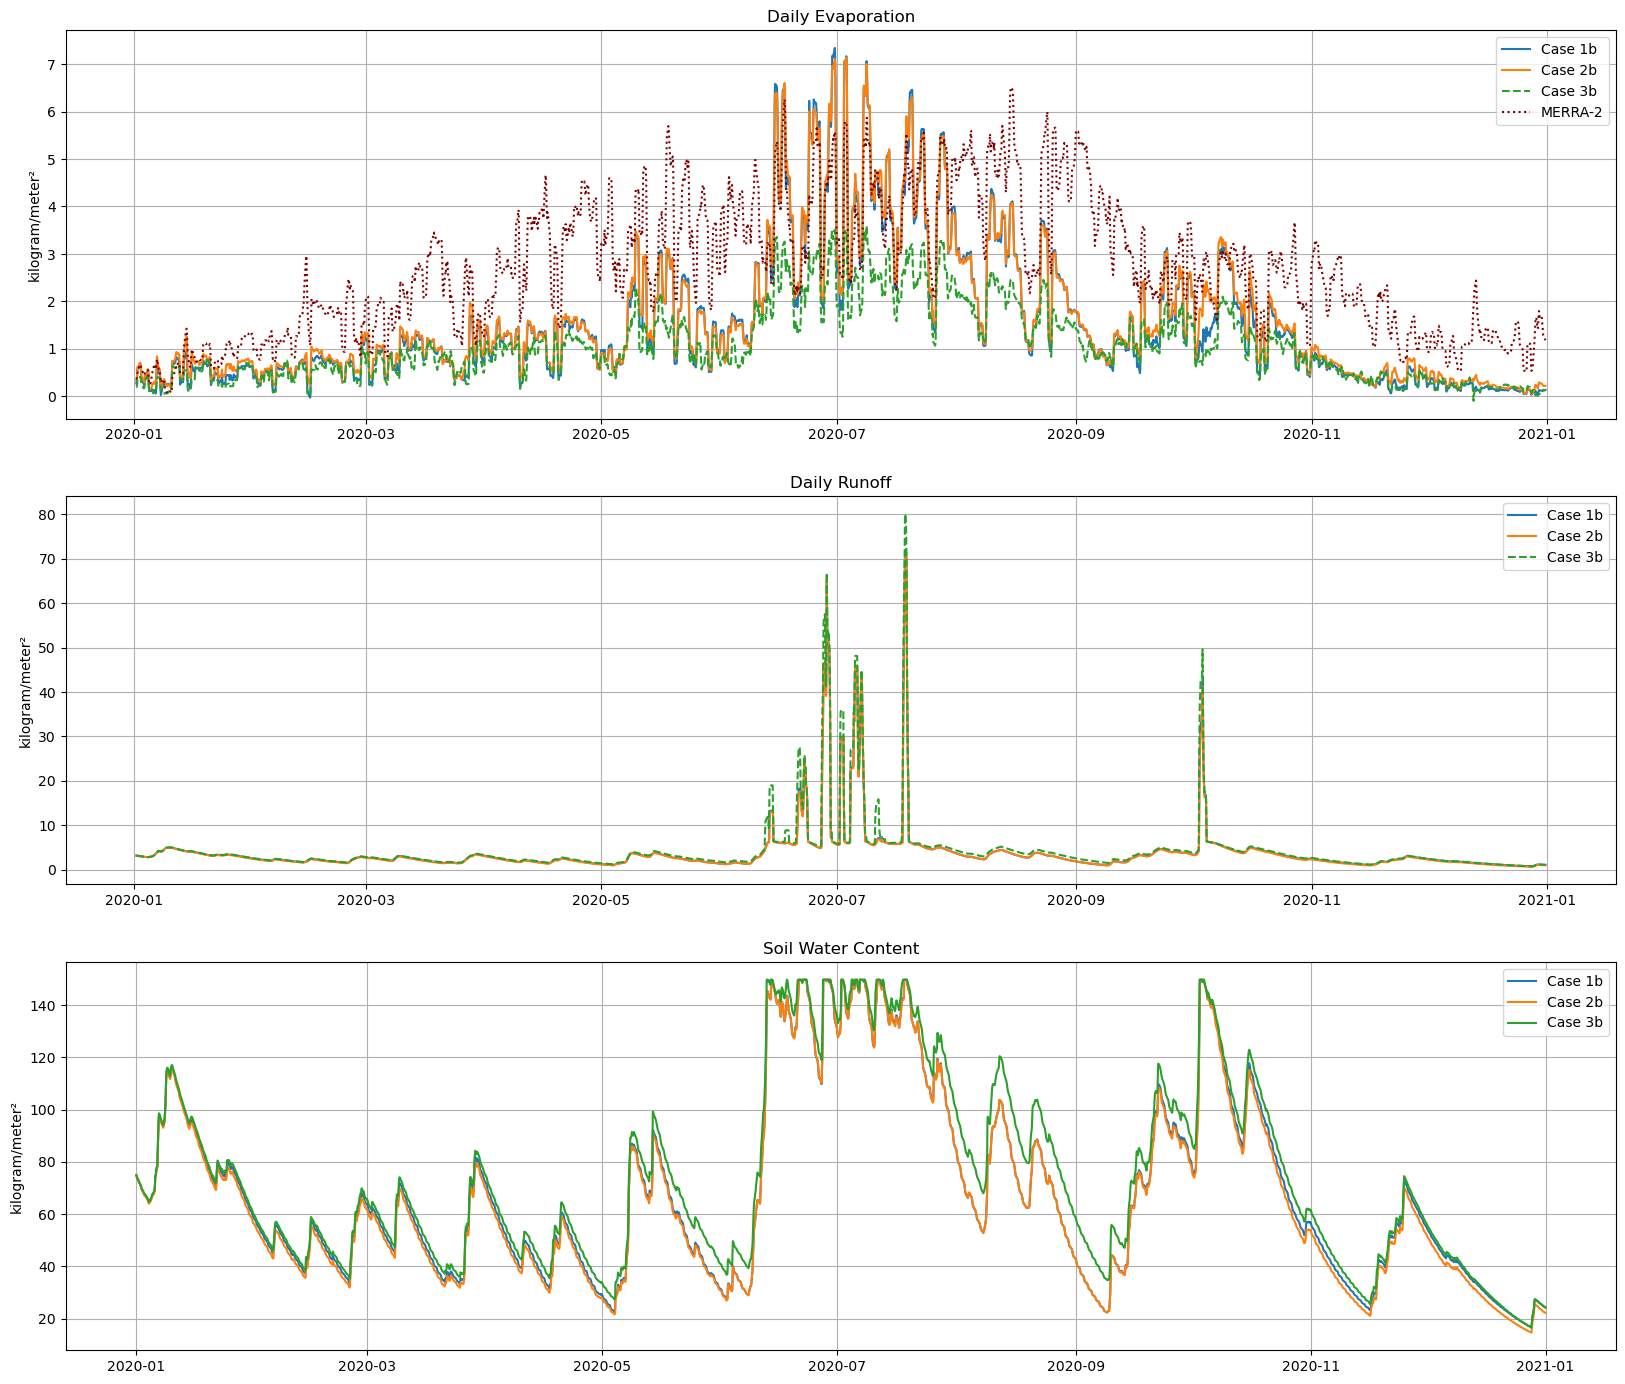

In [15]:
# Plotting block #########
plot_scale = 10
fig1 = plt.figure(figsize = (2*plot_scale, 1.5*plot_scale))
plt.subplots_adjust(top=0.94,bottom=0.06)
plt.subplot(3,1,1)
plt.plot(time_merra2,np.array(pd.Series(e_out_1b).rolling(24,center=True).sum()) * e_out_1b.u)
plt.plot(time_merra2,np.array(pd.Series(e_out_2b).rolling(24,center=True).sum()) * e_out_2b.u)
plt.plot(time_merra2,np.array(pd.Series(e_out_3b).rolling(24,center=True).sum()) * e_out_3b.u, ls="--")
plt.plot(time_merra2,np.array(pd.Series(e_merra2*timestep).rolling(24,center=True).sum()) * e_merra2.u*timestep.u,ls=':', c="maroon")
plt.grid()
plt.title("Daily Evaporation")
plt.legend(["Case 1b","Case 2b","Case 3b","MERRA-2"]) ;

plt.subplot(3,1,2)
plt.plot(time_merra2,np.array(pd.Series(r_out_1b).rolling(24,center=True).sum()) * r_out_1b.u)
plt.plot(time_merra2,np.array(pd.Series(r_out_2b).rolling(24,center=True).sum()) * r_out_2b.u)
plt.plot(time_merra2,np.array(pd.Series(r_out_3b).rolling(24,center=True).sum()) * r_out_3b.u, ls="--")
plt.grid()
plt.title("Daily Runoff")
plt.legend(["Case 1b","Case 2b","Case 3b"]) ;

plt.subplot(3,1,3)
plt.plot(time_merra2,swc_1b)
plt.plot(time_merra2,swc_2b)
plt.plot(time_merra2,swc_3b)
plt.grid()
plt.title("Soil Water Content")
plt.legend(["Case 1b","Case 2b","Case 3b"]) ;


### Answer some questions
There are some stark changes now that baseflow is occurring:
1. Evaporation is lower for all our model cases - lower than MERRA-2 values except during periods when soil is near saturation (June, July, and a brief period in October). Explain why this makes sense.
2. Runoff now shows positive values throughout the year - small but not constant most of the time (baseflow), with spikes during the same periods mentioned in question 1 (surface runoff - Darcy or Horton flow). 
    * What causes the small variations during the unsaturated periods (look at the formulation for baseflow in the `bucket` function)? 
    * If we think of the runoff time series as a streamflow time series, what would we call the spikes (in the *real world*)? 
3. Now that we have baseflow, soil water content is quite a bit lower most of the time. Also, the three time series are much more similar to each other now: our choices of evaporation parameterization don't seem to matter as much. Think in terms of the concept of *feedbacks* we learned about earlier -- would you say that baseflow exerts a positive or negative feedback on soil water content in these models? How so?

-------------------
## D. ...is for diurnal

The code below zooms in on three specific 6-day periods to show the diurnal cycle of our surface water budget terms clearly. In this location, we have chosen periods that correspond to:
1. Mid-summer wet period during the East Asian monsoon (called *Meiyu* in China).
2. A late-summer rain-free period when the soil is still rather wet.
3. A period in late November when cool weather has settled in.

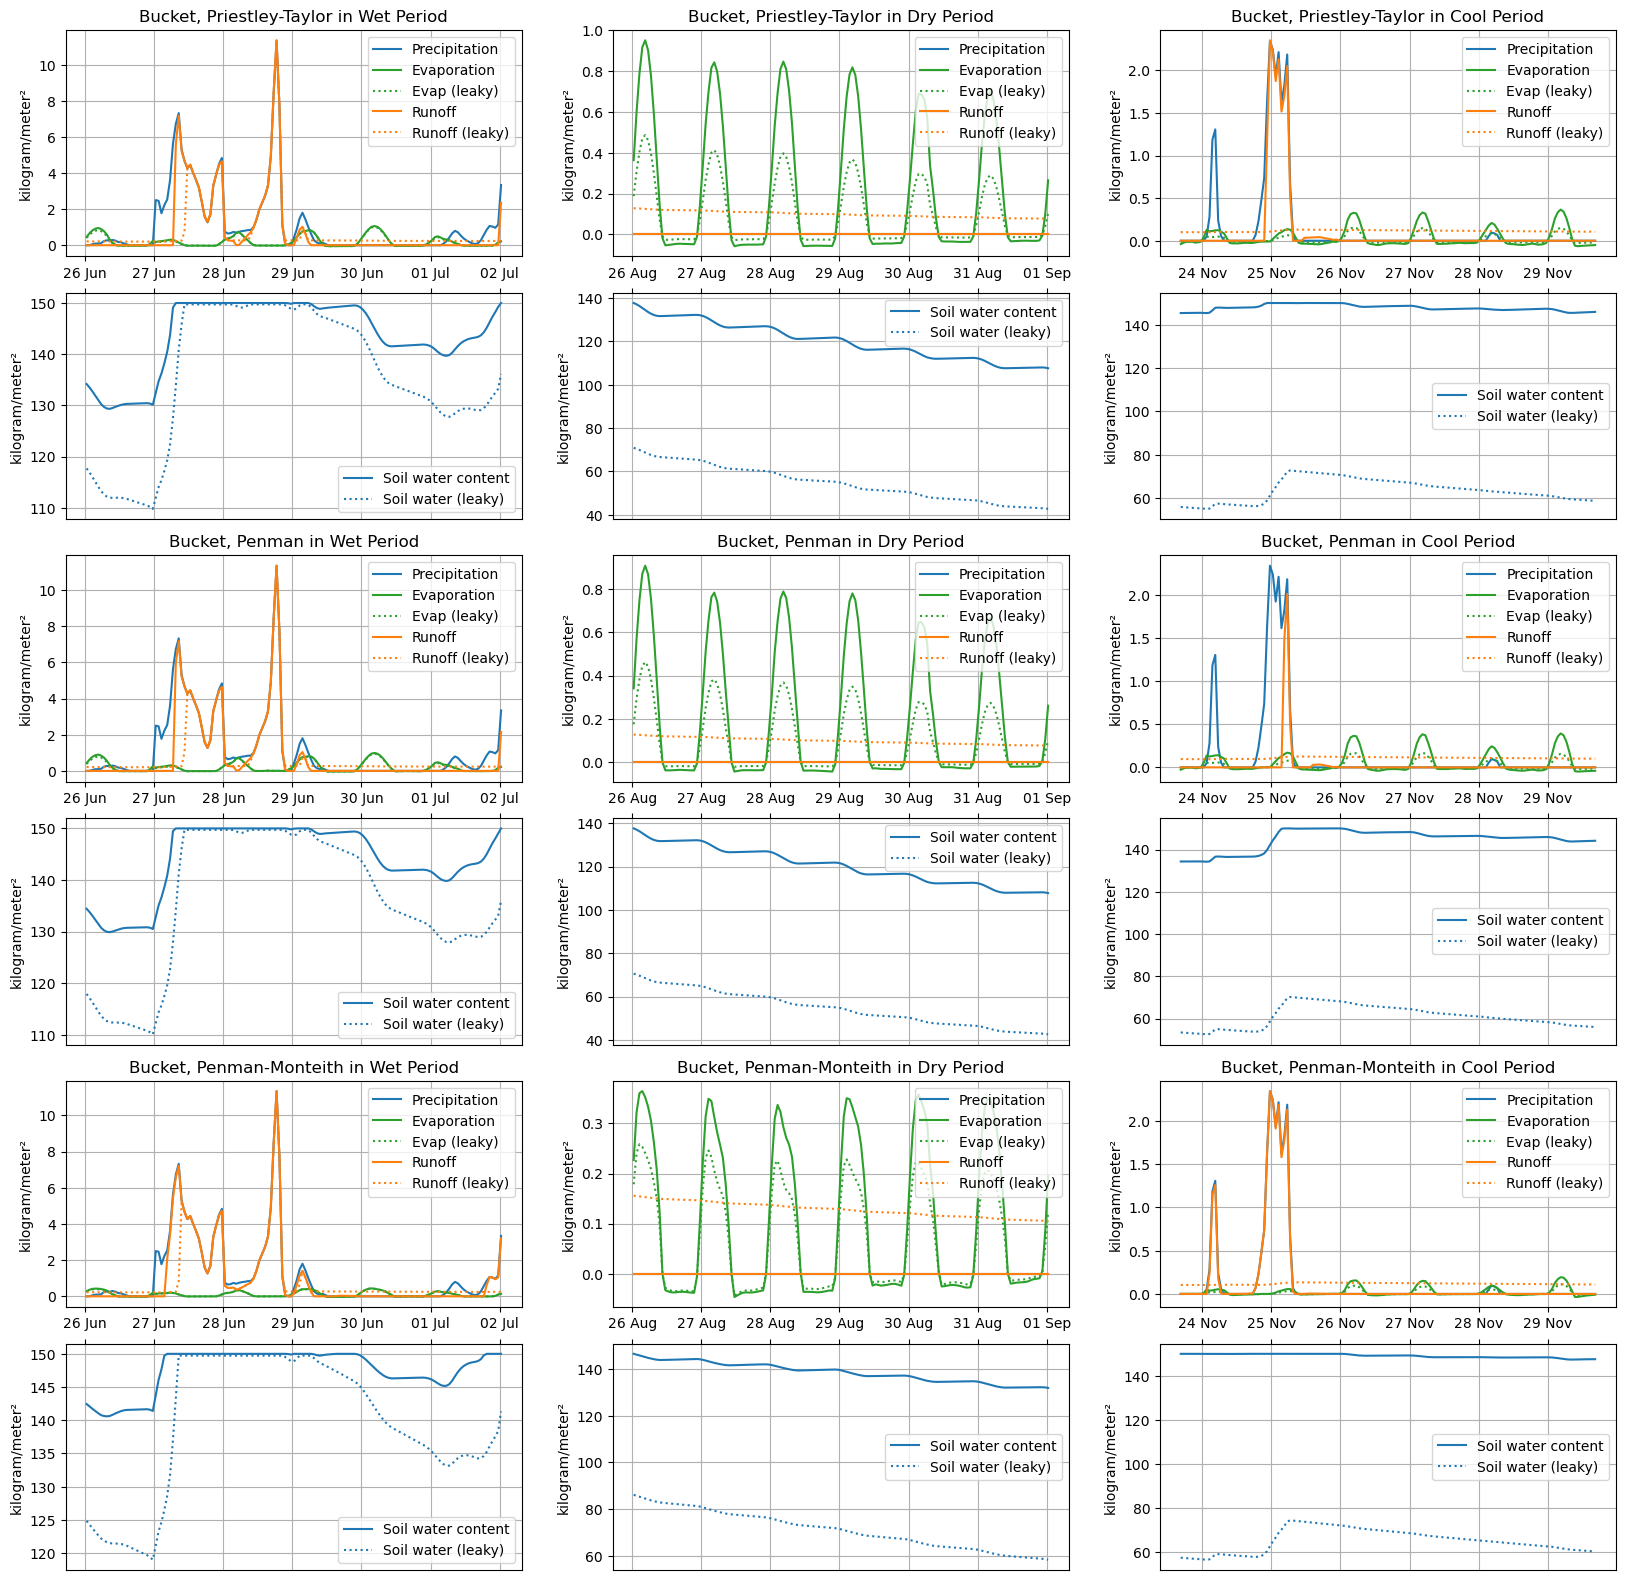

In [16]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
date_fmt = mdates.DateFormatter('%d %b')

fig = plt.figure(figsize = (2*plot_scale, 2*plot_scale))
ax = fig.subplots(6, 3)
plt.subplots_adjust(hspace=0.16)

[[ax[j,i].xaxis.set_major_formatter(date_fmt) for i in range(3)] for j in range(6)]
[[ax[j,i].xaxis.set_major_locator(ticker.MultipleLocator(1)) for i in range(3)] for j in range(6)]

t1w,t2w = 4248,4393
t1d,t2d = 5712,5857
t1c,t2c = 7864,8009

# Priestley-Taylor
ax[0,0].plot(time_merra2[t1w:t2w],p_in_1[t1w:t2w],c='tab:blue')
ax[0,0].plot(time_merra2[t1w:t2w],e_out_1[t1w:t2w],c='tab:green')
ax[0,0].plot(time_merra2[t1w:t2w],e_out_1b[t1w:t2w],c='tab:green',ls=':')
ax[0,0].plot(time_merra2[t1w:t2w],r_out_1[t1w:t2w],c='tab:orange')
ax[0,0].plot(time_merra2[t1w:t2w],r_out_1b[t1w:t2w],c='tab:orange',ls=':')
ax[0,0].grid()
ax[0,0].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[0,0].set_title("Bucket, Priestley-Taylor in Wet Period")
ax[1,0].plot(time_merra2[t1w:t2w],swc_1[t1w:t2w],c='tab:blue')
ax[1,0].plot(time_merra2[t1w:t2w],swc_1b[t1w:t2w],c='tab:blue',ls=':')
ax[1,0].grid()
ax[1,0].legend(["Soil water content","Soil water (leaky)"])
ax[1,0].xaxis.tick_top()
ax[1,0].xaxis.set_ticklabels([]) ;

ax[0,1].plot(time_merra2[t1d:t2d],p_in_1[t1d:t2d],c='tab:blue')
ax[0,1].plot(time_merra2[t1d:t2d],e_out_1[t1d:t2d],c='tab:green')
ax[0,1].plot(time_merra2[t1d:t2d],e_out_1b[t1d:t2d],c='tab:green',ls=':')
ax[0,1].plot(time_merra2[t1d:t2d],r_out_1[t1d:t2d],c='tab:orange')
ax[0,1].plot(time_merra2[t1d:t2d],r_out_1b[t1d:t2d],c='tab:orange',ls=':')
ax[0,1].grid()
ax[0,1].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[0,1].set_title("Bucket, Priestley-Taylor in Dry Period")
ax[1,1].plot(time_merra2[t1d:t2d],swc_1[t1d:t2d],c='tab:blue')
ax[1,1].plot(time_merra2[t1d:t2d],swc_1b[t1d:t2d],c='tab:blue',ls=':')
ax[1,1].grid()
ax[1,1].legend(["Soil water content","Soil water (leaky)"])
ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_ticklabels([]) ;

ax[0,2].plot(time_merra2[t1c:t2c],p_in_1[t1c:t2c],c='tab:blue')
ax[0,2].plot(time_merra2[t1c:t2c],e_out_1[t1c:t2c],c='tab:green')
ax[0,2].plot(time_merra2[t1c:t2c],e_out_1b[t1c:t2c],c='tab:green',ls=':')
ax[0,2].plot(time_merra2[t1c:t2c],r_out_1[t1c:t2c],c='tab:orange')
ax[0,2].plot(time_merra2[t1c:t2c],r_out_1b[t1c:t2c],c='tab:orange',ls=':')
ax[0,2].grid()
ax[0,2].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[0,2].set_title("Bucket, Priestley-Taylor in Cool Period")
ax[1,2].plot(time_merra2[t1c:t2c],swc_1[t1c:t2c],c='tab:blue')
ax[1,2].plot(time_merra2[t1c:t2c],swc_1b[t1c:t2c],c='tab:blue',ls=':')
ax[1,2].grid()
ax[1,2].legend(["Soil water content","Soil water (leaky)"])
ax[1,2].xaxis.tick_top()
ax[1,2].xaxis.set_ticklabels([]) ;

# Penman
ax[2,0].plot(time_merra2[t1w:t2w],p_in_2[t1w:t2w],c='tab:blue')
ax[2,0].plot(time_merra2[t1w:t2w],e_out_2[t1w:t2w],c='tab:green')
ax[2,0].plot(time_merra2[t1w:t2w],e_out_2b[t1w:t2w],c='tab:green',ls=':')
ax[2,0].plot(time_merra2[t1w:t2w],r_out_2[t1w:t2w],c='tab:orange')
ax[2,0].plot(time_merra2[t1w:t2w],r_out_2b[t1w:t2w],c='tab:orange',ls=':')
ax[2,0].grid()
ax[2,0].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[2,0].set_title("Bucket, Penman in Wet Period")
ax[3,0].plot(time_merra2[t1w:t2w],swc_2[t1w:t2w],c='tab:blue')
ax[3,0].plot(time_merra2[t1w:t2w],swc_2b[t1w:t2w],c='tab:blue',ls=':')
ax[3,0].grid()
ax[3,0].legend(["Soil water content","Soil water (leaky)"])
ax[3,0].xaxis.tick_top()
ax[3,0].xaxis.set_ticklabels([]) ;

ax[2,1].plot(time_merra2[t1d:t2d],p_in_2[t1d:t2d],c='tab:blue')
ax[2,1].plot(time_merra2[t1d:t2d],e_out_2[t1d:t2d],c='tab:green')
ax[2,1].plot(time_merra2[t1d:t2d],e_out_2b[t1d:t2d],c='tab:green',ls=':')
ax[2,1].plot(time_merra2[t1d:t2d],r_out_2[t1d:t2d],c='tab:orange')
ax[2,1].plot(time_merra2[t1d:t2d],r_out_2b[t1d:t2d],c='tab:orange',ls=':')
ax[2,1].grid()
ax[2,1].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[2,1].set_title("Bucket, Penman in Dry Period")
ax[3,1].plot(time_merra2[t1d:t2d],swc_2[t1d:t2d],c='tab:blue')
ax[3,1].plot(time_merra2[t1d:t2d],swc_2b[t1d:t2d],c='tab:blue',ls=':')
ax[3,1].grid()
ax[3,1].legend(["Soil water content","Soil water (leaky)"])
ax[3,1].xaxis.tick_top()
ax[3,1].xaxis.set_ticklabels([]) ;

ax[2,2].plot(time_merra2[t1c:t2c],p_in_2[t1c:t2c],c='tab:blue')
ax[2,2].plot(time_merra2[t1c:t2c],e_out_2[t1c:t2c],c='tab:green')
ax[2,2].plot(time_merra2[t1c:t2c],e_out_2b[t1c:t2c],c='tab:green',ls=':')
ax[2,2].plot(time_merra2[t1c:t2c],r_out_2[t1c:t2c],c='tab:orange')
ax[2,2].plot(time_merra2[t1c:t2c],r_out_2b[t1c:t2c],c='tab:orange',ls=':')
ax[2,2].grid()
ax[2,2].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[2,2].set_title("Bucket, Penman in Cool Period")
ax[3,2].plot(time_merra2[t1c:t2c],swc_2[t1c:t2c],c='tab:blue')
ax[3,2].plot(time_merra2[t1c:t2c],swc_2b[t1c:t2c],c='tab:blue',ls=':')
ax[3,2].grid()
ax[3,2].legend(["Soil water content","Soil water (leaky)"])
ax[3,2].xaxis.tick_top()
ax[3,2].xaxis.set_ticklabels([]) ;

# Penman-Monteith 
ax[4,0].plot(time_merra2[t1w:t2w],p_in_3[t1w:t2w],c='tab:blue')
ax[4,0].plot(time_merra2[t1w:t2w],e_out_3[t1w:t2w],c='tab:green')
ax[4,0].plot(time_merra2[t1w:t2w],e_out_3b[t1w:t2w],c='tab:green',ls=':')
ax[4,0].plot(time_merra2[t1w:t2w],r_out_3[t1w:t2w],c='tab:orange')
ax[4,0].plot(time_merra2[t1w:t2w],r_out_3b[t1w:t2w],c='tab:orange',ls=':')
ax[4,0].grid()
ax[4,0].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[4,0].set_title("Bucket, Penman-Monteith in Wet Period")
ax[5,0].plot(time_merra2[t1w:t2w],swc_3[t1w:t2w],c='tab:blue')
ax[5,0].plot(time_merra2[t1w:t2w],swc_3b[t1w:t2w],c='tab:blue',ls=':')
ax[5,0].grid()
ax[5,0].legend(["Soil water content","Soil water (leaky)"])
ax[5,0].xaxis.tick_top()
ax[5,0].xaxis.set_ticklabels([]) ;

ax[4,1].plot(time_merra2[t1d:t2d],p_in_3[t1d:t2d],c='tab:blue')
ax[4,1].plot(time_merra2[t1d:t2d],e_out_3[t1d:t2d],c='tab:green')
ax[4,1].plot(time_merra2[t1d:t2d],e_out_3b[t1d:t2d],c='tab:green',ls=':')
ax[4,1].plot(time_merra2[t1d:t2d],r_out_3[t1d:t2d],c='tab:orange')
ax[4,1].plot(time_merra2[t1d:t2d],r_out_3b[t1d:t2d],c='tab:orange',ls=':')
ax[4,1].grid()
ax[4,1].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[4,1].set_title("Bucket, Penman-Monteith in Dry Period")
ax[5,1].plot(time_merra2[t1d:t2d],swc_3[t1d:t2d],c='tab:blue')
ax[5,1].plot(time_merra2[t1d:t2d],swc_3b[t1d:t2d],c='tab:blue',ls=':')
ax[5,1].grid()
ax[5,1].legend(["Soil water content","Soil water (leaky)"])
ax[5,1].xaxis.tick_top()
ax[5,1].xaxis.set_ticklabels([]) ;

ax[4,2].plot(time_merra2[t1c:t2c],p_in_3[t1c:t2c],c='tab:blue')
ax[4,2].plot(time_merra2[t1c:t2c],e_out_3[t1c:t2c],c='tab:green')
ax[4,2].plot(time_merra2[t1c:t2c],e_out_3b[t1c:t2c],c='tab:green',ls=':')
ax[4,2].plot(time_merra2[t1c:t2c],r_out_3[t1c:t2c],c='tab:orange')
ax[4,2].plot(time_merra2[t1c:t2c],r_out_3b[t1c:t2c],c='tab:orange',ls=':')
ax[4,2].grid()
ax[4,2].legend(["Precipitation","Evaporation","Evap (leaky)","Runoff","Runoff (leaky)"])
ax[4,2].set_title("Bucket, Penman-Monteith in Cool Period")
ax[5,2].plot(time_merra2[t1c:t2c],swc_3[t1c:t2c],c='tab:blue')
ax[5,2].plot(time_merra2[t1c:t2c],swc_3b[t1c:t2c],c='tab:blue',ls=':')
ax[5,2].grid()
ax[5,2].legend(["Soil water content","Soil water (leaky)"])
ax[5,2].xaxis.tick_top()
ax[5,2].xaxis.set_ticklabels([]) ;


### Answer some questions
1. There is a clear peak every day in evaporation - what time of day *locally* is the peak for each day (note that the times are UTC, not local for China, and the labels mark 0000UTC)? What determines this time of peak evaporation?
2. There is little difference between leaky and unleaky bucket formulations among all 3 parameterizations in the wet period. But for the selected dry period, evaporation is ~30-50% less for the leaky bucket. Why might this be so? (notice the vertical scales are different between columns)
3. For the leaky bucket formulation, total runoff is non-zero even during days with no rain, yet decreases gradually during dry periods. Why does it decrease (i.e., what is governing the baseflow rate)?
4. Soil water content increases when there rainfall. During dry periods (rain-free days) we clearly see the "stairsteps" mentioned earler. What causes there to be one stair per day?
5. Nighttime evaporation can be negative. This is most obvious in the middle column. What is this and is it realistic?